## Training Model
### Objective
The objective of this notebook is to train regression model

Data: porter.csv

Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below:

* market id: integer id for the market where the restaurant lies
* created at: the timestamp at which the order was placed
* actual delivery time: the timestamp when the order was delivered
* store_primary_category: category for the restaurant
* order protocol: integer code value for order protocol(how the order was placed le: through porter, call to restaurant, pre booked, third part etc)
* total items subtotal: final price of the order
* num_distinct items: the number of distinct items in the order
* min_item_price: price of the cheapest item in the order
* max_item_price: price of the costliest item in order
* total_onshift_partners: number of delivery partners on duty at the time order was placed
* total_busy_partners: number of delivery partners attending to other tasks
* total outstanding_orders: total number of orders to be fulfilled at the moment

### 1. Exploratory Data Analysis

In [1]:
!pip install -r requirements.txt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from joblib import dump, load
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

sns.set_theme(style="ticks", palette="pastel")

def remove_outliers(df, col: str):
    q3 = np.quantile(df[col], 0.75)
    q1 = np.quantile(df[col], 0.25)
    l_lmt = q1 - 1.5 * (q3 - q1)
    u_lmt = q3 + 1.5 * (q3 - q1)
    return df[(df[col] >= l_lmt) & (df[col] <= u_lmt)].copy()

#Read Sample Dataset
#raw_df = pd.read_csv('/content/drive/My Drive/ISS/EBA5007/D2/data/porter.csv')
raw_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,minutes_to_delivery
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [ ]:
#Check number of records and columns
print(raw_df.shape)

(197428, 14)


In [ ]:
#Check % of missing values
raw_df.isnull().sum()/raw_df.shape[0]*100

market_id                   0.499929
created_at                  0.000000
actual_delivery_time        0.003546
store_id                    0.000000
store_primary_category      2.411006
order_protocol              0.503981
total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.000000
max_item_price              0.000000
total_onshift_partners      8.236927
total_busy_partners         8.236927
total_outstanding_orders    8.236927
dtype: float64

In [4]:
# Get target metric 'minutes_to_delivery' from (actual_delivery_time - created_at)
raw_df['actual_delivery_time'] = pd.to_datetime(raw_df['actual_delivery_time'])
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
raw_df['minutes_to_delivery'] = round((raw_df['actual_delivery_time'] - raw_df['created_at']).dt.total_seconds()/60)

# Convert market_id and 'order_protocol' to object
raw_df['market_id'] = raw_df['market_id'].astype(str)
raw_df['order_protocol'] = raw_df['order_protocol'].astype(str)


raw_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,minutes_to_delivery
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0


In [ ]:
raw_df.describe(include='all')

<ipython-input-7-19bf86c9bdc5>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  raw_df.describe(include='all')
<ipython-input-7-19bf86c9bdc5>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  raw_df.describe(include='all')


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,minutes_to_delivery
count,197428,197428,197421,197428,192668,197428,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197421.000000
unique,7,180985,178110,6743,74,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2.0,2015-02-11 19:50:43,2015-02-11 20:40:45,d43ab110ab2489d6b9b2caa394bf920f,american,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,55058,6,5,937,19399,54725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2014-10-19 05:24:15,2015-01-21 15:58:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-02-18 06:00:44,2015-02-19 22:45:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,48.470492
std,NaN,NaN,NaN,NaN,NaN,NaN,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,320.494384
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,2.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,35.000000


In [5]:
# Drop outliers, negative, and missing values
df = raw_df.dropna()
df = remove_outliers(df, 'minutes_to_delivery')
df = remove_outliers(df, 'total_items')
df = remove_outliers(df, 'subtotal')
df = remove_outliers(df, 'min_item_price')
df = remove_outliers(df, 'max_item_price')
df = (df
      .loc[df['total_onshift_partners'] >= 0,:]
      .loc[df['total_busy_partners'] >= 0,:]
      .loc[df['total_outstanding_orders'] >= 0,:]
)

print(df.shape)
#Check % of missing values
df.isnull().sum()/df.shape[0]*100

(149926, 15)


market_id                   0.0
created_at                  0.0
actual_delivery_time        0.0
store_id                    0.0
store_primary_category      0.0
order_protocol              0.0
total_items                 0.0
subtotal                    0.0
num_distinct_items          0.0
min_item_price              0.0
max_item_price              0.0
total_onshift_partners      0.0
total_busy_partners         0.0
total_outstanding_orders    0.0
minutes_to_delivery         0.0
dtype: float64

In [ ]:
# Correlation between numerical variables
plt_df = df.sample(frac=0.05)
g = sns.pairplot(plt_df[['total_items','subtotal','num_distinct_items','min_item_price','max_item_price','total_onshift_partners','total_busy_partners', 'total_outstanding_orders', 'minutes_to_delivery']])

Output hidden; open in https://colab.research.google.com to view.

In [6]:
# Feature Engineering (numerical)

# 1. Average Item Price
df['avg_item_price'] = df['subtotal'] / df['total_items']

# 2. Range of Item Prices
df['price_range'] = df['max_item_price'] - df['min_item_price']

# 3. Min max price ratio
df['price_ratio'] = df['max_item_price'] / df['min_item_price']

# 4. Normalized price range
df['normalized_price_range'] = df['price_range'] / df['subtotal']

# 5. Ratio of Total Items to Total Distinct Items
df['items_to_distinct_items_ratio'] = df['total_items'] / df['num_distinct_items']



# 6. Ratio of Busy Partners to Total On-Shift Partners
df['busy_partners_ratio'] = df['total_busy_partners'] / df['total_onshift_partners']

# 7. Ratio of Outstanding Orders to Total On-Shift Partners
df['orders_to_partners_ratio'] = df['total_outstanding_orders'] / df['total_onshift_partners']

# 8. Ratio of Outstanding Orders to Total Busy Partners
df['orders_to_busy_partners_ratio'] = df['total_outstanding_orders'] / df['total_busy_partners']



In [ ]:
# Correlation between numerical variables (order-related)
plt_df = df.sample(frac=0.05)
g = sns.pairplot(plt_df[['total_items','subtotal','num_distinct_items','min_item_price','max_item_price', 'avg_item_price', 'price_range', 'price_ratio', 'normalized_price_range', 'items_to_distinct_items_ratio', 'minutes_to_delivery']])

Output hidden; open in https://colab.research.google.com to view.

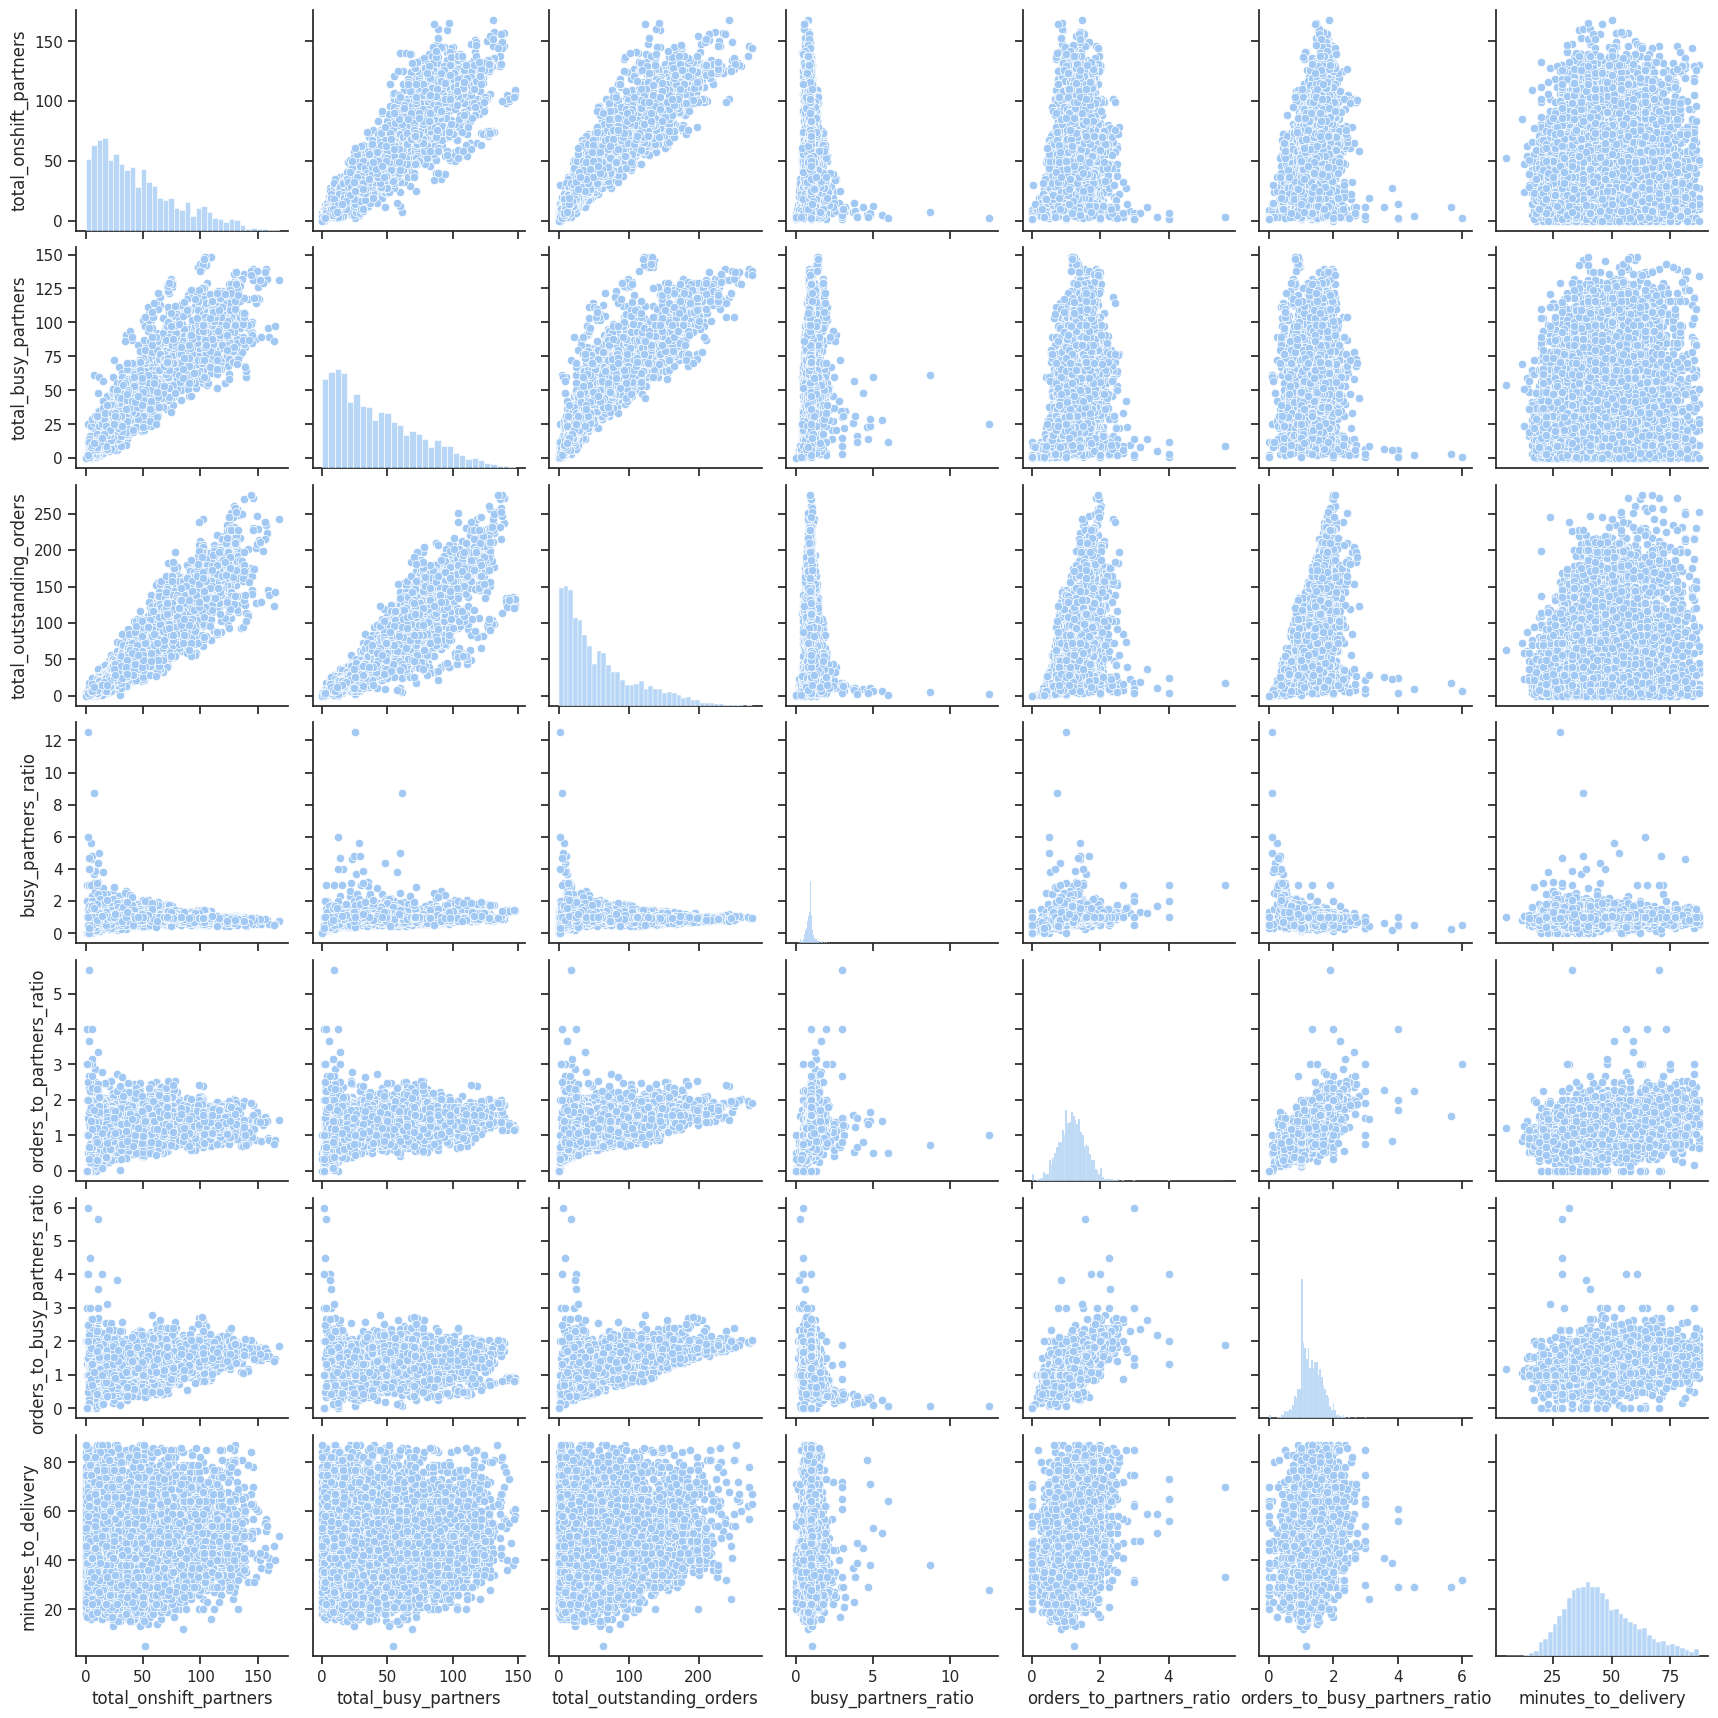

In [ ]:
# Correlation between numerical variables (shift-related)
plt_df = df.sample(frac=0.05)
g = sns.pairplot(plt_df[['total_onshift_partners','total_busy_partners', 'total_outstanding_orders', 'busy_partners_ratio', 'orders_to_partners_ratio', 'orders_to_busy_partners_ratio', 'minutes_to_delivery']])

### Categorical

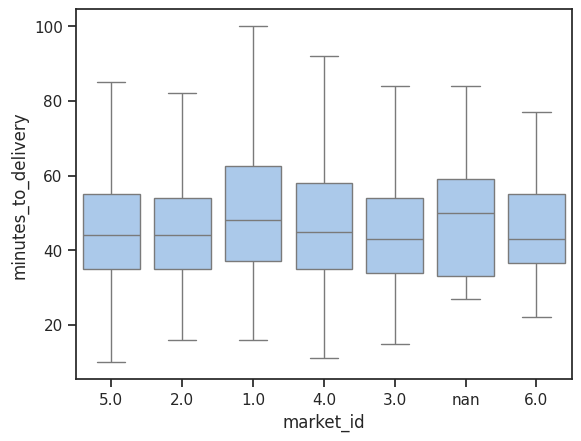

In [ ]:
g = sns.boxplot(x="market_id", y="minutes_to_delivery", data=plt_df, showfliers = False)

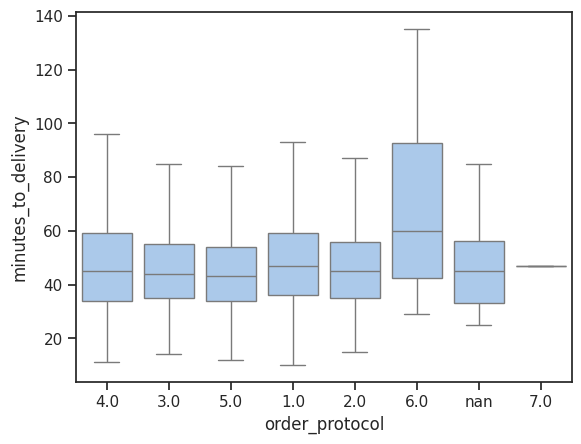

In [ ]:
g = sns.boxplot(x="order_protocol", y="minutes_to_delivery", data=plt_df, showfliers = False)

In [7]:
# Check data aggregated by store_primary_category
df_store_cat_agg = df.groupby('store_primary_category').agg(
    num_deliveries=('store_primary_category', 'count'), # number of delivery records for each store
    avg_minutes_to_delivery=('minutes_to_delivery', 'mean') # avg delivery time
).reset_index()
df_store_cat_agg

,store_primary_category,num_deliveries,avg_minutes_to_delivery
0,afghan,86,46.523256
1,african,8,52.875000
2,alcohol,1461,42.874743
3,alcohol-plus-food,1,51.000000
4,american,15482,45.081449
...,...,...,...
67,thai,5531,46.305008
68,turkish,205,43.443902
69,vegan,217,46.059908
70,vegetarian,692,44.539017


In [8]:
# Categorize based on num_categories (group together other and below)
df_store_cat_agg['store_primary_category_agg'] = np.where(
    df_store_cat_agg['num_deliveries'] > 4500,
    df_store_cat_agg['store_primary_category'],
    'other')
df_store_cat_agg

,store_primary_category,num_deliveries,avg_minutes_to_delivery,store_primary_category_agg
0,afghan,86,46.523256,other
1,african,8,52.875000,other
2,alcohol,1461,42.874743,other
3,alcohol-plus-food,1,51.000000,other
4,american,15482,45.081449,american
...,...,...,...,...
67,thai,5531,46.305008,thai
68,turkish,205,43.443902,other
69,vegan,217,46.059908,other
70,vegetarian,692,44.539017,other


In [9]:
# aggregate df by store_id

df_store_agg = df.groupby('store_id').agg(
    num_deliveries=('store_id', 'count'), # number of delivery records for each store
    avg_minutes_to_delivery=('minutes_to_delivery', 'mean') # avg delivery time
).reset_index()
df_store_agg


,store_id,num_deliveries,avg_minutes_to_delivery
0,0004d0b59e19461ff126e3a08a814c33,112,37.839286
1,00053f5e11d1fe4e49a221165b39abc9,1,25.000000
2,0006aabe0ba47a35c0b0bf6596f85159,3,45.333333
3,000a91f3e374e6147d58ed1814247508,9,60.888889
4,0029f088c57ad3b6ec589f9ba4f7a057,9,46.333333
...,...,...,...
5470,ffb14e8b6e84eb9ad09f15443be54561,31,48.645161
5471,ffba90305889de903ea9b6a6ec4376d9,2,48.000000
5472,ffc58105bf6f8a91aba0fa2d99e6f106,3,18.000000
5473,ffd52f3c7e12435a724a8f30fddadd9c,16,53.500000


In [10]:
# Group store with >50 deliveries as popular
df_store_agg['popular_store'] = np.where(
    df_store_agg['num_deliveries'] > 50,
    1,
    0)
df_store_agg

,store_id,num_deliveries,avg_minutes_to_delivery,popular_store
0,0004d0b59e19461ff126e3a08a814c33,112,37.839286,1
1,00053f5e11d1fe4e49a221165b39abc9,1,25.000000,0
2,0006aabe0ba47a35c0b0bf6596f85159,3,45.333333,0
3,000a91f3e374e6147d58ed1814247508,9,60.888889,0
4,0029f088c57ad3b6ec589f9ba4f7a057,9,46.333333,0
...,...,...,...,...
5470,ffb14e8b6e84eb9ad09f15443be54561,31,48.645161,0
5471,ffba90305889de903ea9b6a6ec4376d9,2,48.000000,0
5472,ffc58105bf6f8a91aba0fa2d99e6f106,3,18.000000,0
5473,ffd52f3c7e12435a724a8f30fddadd9c,16,53.500000,0


In [11]:
# Merge back categories to df
df2 = (df
       .merge(
           df_store_cat_agg[['store_primary_category','store_primary_category_agg']],
           on='store_primary_category',
           how='left')
       .merge(
           df_store_agg[['store_id','popular_store']],
           on='store_id',
           how='left')
)
df2.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,avg_item_price,price_range,price_ratio,normalized_price_range,items_to_distinct_items_ratio,busy_partners_ratio,orders_to_partners_ratio,orders_to_busy_partners_ratio,store_primary_category_agg,popular_store
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,...,860.250000,682,2.224417,0.198198,1.000000,0.424242,0.636364,1.500000,american,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,...,1900.000000,0,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,mexican,0
2,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,f0ade77b43923b38237db569b016ba25,indian,3.0,4,4771,3,820,...,1192.750000,784,1.956098,0.164326,1.333333,0.750000,2.250000,3.000000,indian,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,ef1e491a766ce3127556063d49bc2f98,italian,1.0,1,1525,1,1525,...,1525.000000,0,1.000000,0.000000,1.000000,1.200000,1.600000,1.333333,italian,0
4,1.0,2015-02-08 02:04:17,2015-02-08 03:27:13,ef1e491a766ce3127556063d49bc2f98,italian,1.0,3,4375,3,1325,...,1458.333333,300,1.226415,0.068571,1.000000,0.666667,0.500000,0.750000,italian,0


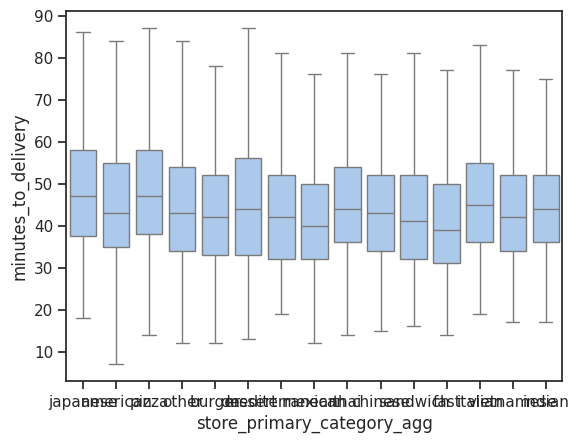

In [ ]:
plt_df2 = df2.sample(frac=0.05)
g = sns.boxplot(x="store_primary_category_agg", y="minutes_to_delivery", data=plt_df2, showfliers = False)

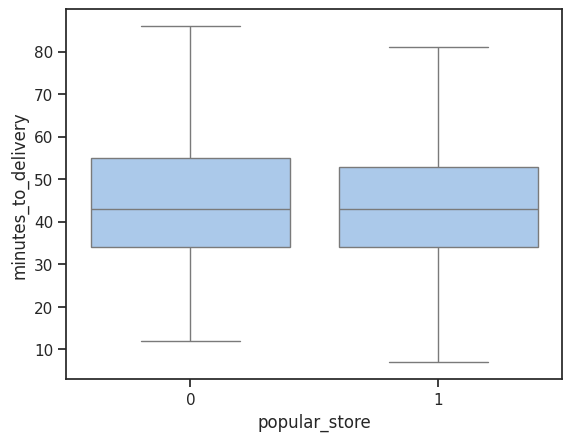

In [ ]:
g = sns.boxplot(x="popular_store", y="minutes_to_delivery", data=plt_df2, showfliers = False)

### 3. Data Preprocessing

In [12]:
#Select features
features = ['popular_store','store_primary_category_agg','order_protocol','market_id','total_outstanding_orders','avg_item_price']
numeric_features = ['total_outstanding_orders','avg_item_price']
categorical_features = ['popular_store','store_primary_category_agg','order_protocol','market_id']
label = 'minutes_to_delivery'

numeric_transformer = MinMaxScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

dat = preprocessor.fit_transform(df2[features])
new_cols = numeric_features + \
list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Convert the sparse matrix to a dense array
dat_dense = dat.toarray()

# Create a DataFrame from the dense array
trf_df = pd.DataFrame(dat_dense, columns=new_cols)
trf_df.head()

,total_outstanding_orders,avg_item_price,popular_store_0,popular_store_1,store_primary_category_agg_american,store_primary_category_agg_burger,store_primary_category_agg_chinese,store_primary_category_agg_dessert,store_primary_category_agg_fast,store_primary_category_agg_indian,...,order_protocol_6.0,order_protocol_7.0,order_protocol_nan,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,market_id_nan
0,0.075540,0.143399,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.007194,0.316719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.064748,0.198825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.028777,0.254209,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.010791,0.243096,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Modeling
#### 4.1 Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df2[features], \
                                                    df2[label], \
                                                    test_size=0.2, \
                                                    random_state=0)
X_train.head()

,popular_store,store_primary_category_agg,order_protocol,market_id,total_outstanding_orders,avg_item_price
40545,1,sandwich,3.0,4.0,138.0,501.666667
57305,0,italian,3.0,4.0,115.0,1147.500000
105195,0,mediterranean,3.0,2.0,31.0,1500.000000
67569,0,other,2.0,4.0,9.0,340.714286
81076,0,mediterranean,1.0,2.0,56.0,880.000000


#### 4.2 Train Regression

In [14]:
random_forest = RandomForestRegressor(n_estimators=500,
                                       max_depth=5,
                                       max_features = 'sqrt',
                                       n_jobs=-1,
                                       random_state = 42)

rf_pipe = Pipeline(steps=[("preprocessor", preprocessor),\
                      ("regression", random_forest)]
              )

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['total_outstanding_orders',
                                                   'avg_item_price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['popular_store',
                                                   'store_primary_category_agg',
                                                   'order_protocol',
                                                   'market_id'])])),
                ('regression',
                 RandomForestRegressor(max_depth=5, max_features='sqrt',
                                       n_estimators=500, n_jobs=-1,
                                       random_state=42))])

### 5. Evaluation

In [20]:
print(np.sqrt(mean_squared_error(y_train, rf_pipe.predict(X_train))))
print(np.sqrt(mean_squared_error(y_test, rf_pipe.predict(X_test))))

13.940140675450602
13.964289145185646


# Export model

In [21]:
print('Deploy...')
dump(rf_pipe, '/content/drive/My Drive/ISS/EBA5007/D2/models/mdl_porter.joblib')
dump(features, '/content/drive/My Drive/ISS/EBA5007/D2/models/raw_features_porter.joblib')
print('Training completed.')

Deploy...
Training completed.
